In [1]:
import torch
from fastai.text.all import *

%matplotlib inline

In [2]:
dataset_path = untar_data(URLs.IMDB)
dataset_files = get_text_files(dataset_path, folders=['train', 'test'])

tok_rules = [
    lowercase,
    fix_html,
    spec_add_spaces,
    rm_useless_spaces,
]
x_tfms = [
    Tokenizer.from_folder(dataset_path, tok=TokenizeWithRules(WordTokenizer(), tok_rules), rules=[]),
    Numericalize(max_vocab=64_000)
]
y_tfms = [
    parent_label, 
    Categorize()
]

splitter = GrandparentSplitter(train_name='train', valid_name='test')(dataset_files)
dsets = Datasets(dataset_files, [x_tfms, y_tfms], splits = splitter)
dloaders = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

2023-11-29 00:33:08.178332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 00:33:08.868147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-29 00:33:09.373801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 00:33:09.377666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 00:33:09.377702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

In [3]:
vocab_len = len(x_tfms[1].vocab)
vocab_len

64008

In [4]:
# note the drop_last - needed to always have bs=16, and drop leftovers
dloaders = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input, bs=16, drop_last=True)
dloaders.one_batch()

(TensorText([[12628,   506,   103,  ...,    30,   158,   699],
             [ 1926, 11594,    19,  ...,     1,     1,     1],
             [ 3921,    10,    66,  ...,     1,     1,     1],
             ...,
             [ 3279,  2731,  1010,  ...,     1,     1,     1],
             [   23,   235,  1002,  ...,     1,     1,     1],
             [   20, 58857,    20,  ...,     1,     1,     1]], device='cuda:0'),
 TensorCategory([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0],
                device='cuda:0'))

## multi-layer LSTM using pytorch 

In [12]:
class LstmModelCallback(Callback):
    def after_batch(self): 
        self.model.reset()
    def before_batch(self):
        batch_shape = self.x.shape
        self.model.setup(batch_shape[0])

class LstmModel(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_size, 
                 hidden_size,
                 output_size,
                 batch_size, 
                 num_layers=1, 
                 bidirectional=False) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.d = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, 
                            hidden_size, 
                            num_layers=num_layers, 
                            bidirectional=bidirectional,
                            batch_first=True)
        self.output = nn.Linear(hidden_size*self.d, output_size)
        
        # hidden states for LSTM
        self.lstm_hidden_state = torch.zeros(self.d*self.num_layers, batch_size, self.hidden_size).to(device='cuda')
        self.lstm_cell_state = torch.zeros(self.d*self.num_layers, batch_size, self.hidden_size).to(device='cuda')

    def forward(self, x):
        # recurrence
        inputs = self.embedding(x)
        hc = (self.lstm_hidden_state, self.lstm_cell_state)
        
        o,_ = self.lstm(inputs, hc)
        
        last_output = o[:, -1, :]
        last_output = F.relu(last_output)
        return self.output(last_output)
        
    
    def reset(self):
        self.lstm_hidden_state.zero_()
        self.lstm_cell_state.zero_()

    def setup(self, batch_size):
        if self.batch_size != batch_size:
            self.batch_size = batch_size
            self.lstm_hidden_state = torch.zeros(self.d*self.num_layers, batch_size, self.hidden_size).to(device='cuda')
            self.lstm_cell_state = torch.zeros(self.d*self.num_layers, batch_size, self.hidden_size).to(device='cuda')
        
        
lstm = LstmModel(vocab_size=vocab_len, 
            embedding_size=32, 
            hidden_size=32, 
            output_size=2, 
            batch_size=16, 
            num_layers=2)
lstm.cuda()

learner = Learner(dloaders, 
                  lstm, 
                  loss_func=F.cross_entropy, 
                  metrics=accuracy, 
                  cbs=LstmModelCallback)

b = dloaders.one_batch()
print(b[0].shape)
print(b[1].shape)
learner.forward(b[0])

torch.Size([16, 2789])
torch.Size([16])


TensorText([[-0.0137, -0.0751],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590],
            [-0.0211, -0.0590]], device='cuda:0', grad_fn=<AliasBackward0>)

SuggestedLRs(valley=3.630780702224001e-05)

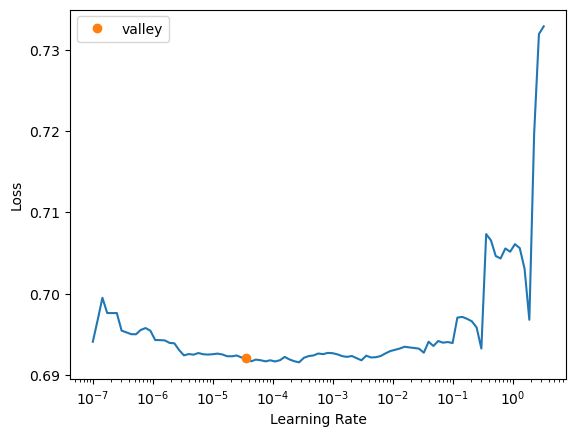

In [13]:
learner.lr_find()

In [8]:
learner.fit_one_cycle(10, 2.51e-05)

DUPA: torch.Size([8, 16])
DUPA: torch.Size([8, 16])
DUPA: torch.Size([8, 16])
DUPA: torch.Size([8, 16])
DUPA: torch.Size([8, 16])
DUPA: torch.Size([8, 16])
DUPA: torch.Size([8, 16])
DUPA: torch.Size([8, 16])
DUPA: torch.Size([8, 16])
DUPA: torch.Size([8, 16])


In [14]:
# clean gpu memory
import gc

learner = None
lstm = None
gc.collect()
torch.cuda.empty_cache()

## bidrectional LSTM

In [15]:
lstm = LstmModel(vocab_size=vocab_len, 
            embedding_size=32, 
            hidden_size=32, 
            output_size=2, 
            batch_size=16, 
            num_layers=2,
            bidirectional=True)
lstm.cuda()

learner = Learner(dloaders, 
                  lstm, 
                  loss_func=F.cross_entropy, 
                  metrics=accuracy, 
                  cbs=LstmModelCallback)

SuggestedLRs(valley=0.0020892962347716093)

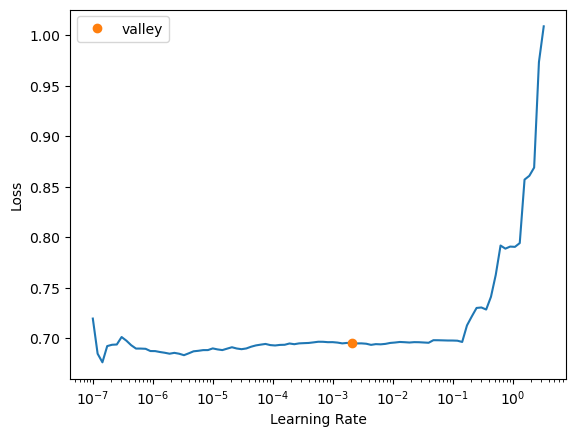

In [16]:
learner.lr_find()

In [17]:
learner.fit_one_cycle(10, 0.0020)